In [349]:
import numpy as np
import gym
import math
import time
import mdptoolbox.example as ex
from mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
import time, pickle, os
import seaborn as sns
import matplotlib.pyplot as plt
import itertools



In [505]:
def prettify_output(algo, value_array, policy_array, num_iters, total_time):
    title = {
        0: 'Value Iteration',
        1: 'Policy Iteration',
        2: 'Q-Learning'
    }[algo]
    print("{} Value Array:\n{}".format(title, value_array))
    print("{} Output Policy:\n{}".format(title, policy_array))
    print("{} - Time per iteration:\n{}".format(title, total_time/num_iters))
    print("{} - Total Iterations:\n{}".format(title, num_iters))
    print()
    
def compare_policies(p1, p2):
    p1, p2 = np.array(p1), np.array(p2)
    if np.array_equal(p1, p2):
        print("The policies are equal")
    else:
        print("There were {} differences in the policies".format(len(p1)-sum(p1 == p2)))
    print()
    
def compare_values(v1, v2):
    v1, v2 = np.array(v1), np.array(v2)
    print("The difference between the value arrays is {}".format(np.mean(abs(sum(v1-v2)))))
    print()
    
def eval_qpolicy(policy):
    x = sum(policy)
    y = len(policy) - x
    return 4 * y + 2 * x

In [116]:
def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

In [530]:
m = generate_random_map(16, .5)
print(m)

['SFHHHHFHFHFFHHHH', 'FHFHFFHHHFHFHFHF', 'FHHHHFHHHHHFFFHH', 'FFFFFFHHFHFHFFHH', 'HHHFFFFFFFFFHHFF', 'FHHFFFFFFFHHFFFH', 'FFFFFHFHHHFFHFFH', 'HFHFFFFFFFFHHHFH', 'FFHHHHHFFFFHFHHH', 'HHHHHFFHFFHFFHFF', 'FHHFHHHHFFFFHFFF', 'FFHHHFHFFFHFFFHH', 'HHFHFHHFFFHHFFFH', 'HFFFFHFHFFFHHHFF', 'FHHFFFHFHHHHFHFH', 'HFHFFHFFHFFFFFFG']


In [369]:
def value_iteration(env, max_iterations=100000, lmbda=0.9):
    total_iter = 0
    stateValue = [0 for i in range(env.nS)]
    newStateValue = stateValue.copy()
    for i in range(max_iterations):
        for state in range(env.nS):
            action_values = []      
            for action in range(env.nA):
                state_value = 0
                for i in range(len(env.P[state][action])):
                    prob, next_state, reward, done = env.P[state][action][i]
                    state_action_value = prob * (reward + lmbda*stateValue[next_state])
                    state_value += state_action_value
                action_values.append(state_value)      #the value of each action
                best_action = np.argmax(np.asarray(action_values))   # choose the action which gives the maximum value
                newStateValue[state] = action_values[best_action]  #update the value of the state
        if i > 1000: 
            if sum(stateValue) - sum(newStateValue) < 1e-04:   # if there is negligible difference break the loop
                break
                print(i)
        elif stateValue == newStateValue:
            break
        else:
            stateValue = newStateValue.copy()
        total_iter +=1
    
    return stateValue, total_iter

def get_policy(env,stateValue, lmbda=0.9):
    policy = [0 for i in range(env.nS)]
    for state in range(env.nS):
        action_values = []
        for action in range(env.nA):
            action_value = 0
            for i in range(len(env.P[state][action])):
                prob, next_state, r, _ = env.P[state][action][i]
                action_value += prob * (r + lmbda * stateValue[next_state])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
    return policy

def get_qpolicy(q):
    policy = [0 for i in range(len(q))]
    for i in range(len(q)):
        policy[i] = np.argmax(q[i])
    return policy

In [305]:
STEP_REWARD = 0.0
LOSE_REWARD = 0.0
WIN_REWARD = 1.0

def avg_reward(env, s, a):
    avg_reward = 0
    for prob, next_s, reward, done in env.P[s][a]:
        if not done:
            avg_reward += prob * STEP_REWARD
        elif reward == 0.0:
#             avg_reward += prob * (-5)
            avg_reward += prob * LOSE_REWARD
        else:
#             avg_reward += prob * 10
            avg_reward += prob * WIN_REWARD
    return avg_reward
            
def random_policy(env):
    return np.random.randint(0, 4, size=env.nS)

def one_step_lookahead(env, s, value_function, gamma):
    action_values = np.zeros(env.nA)
    for a in range(env.nA):
        value = avg_reward(env, s, a)
        for p, next_s, _, _ in env.P[s][a]:
            value += gamma * p * value_function[next_s]
        action_values[a] = value
    return action_values
    
def evaluate_policy(env, policy, max_backups=1000, tol=1e-6, gamma=.9):
    old_value = np.zeros(env.nS)
    for i in range(max_backups):
        new_value = np.zeros(env.nS)
        for s in range(env.nS):
            action_values = one_step_lookahead(env, s, old_value, gamma)
            new_value[s] = action_values[policy[s]]
        if np.max(np.abs(new_value-old_value)) < tol:
            break
        old_value = new_value
    return new_value

def greedy_policy(env, value_function, gamma):
    policy = np.zeros(env.nS, dtype=np.int32)
    for s in range(env.nS):
        action_values = one_step_lookahead(env, s, value_function, gamma)
        policy[s] = np.argmax(action_values)
    return policy

def policy_iteration(env, max_steps=100, gamma=.9):
    total_iters = 0
    old_policy = random_policy(env)
    for i in range(max_steps):
        value_function = evaluate_policy(env, old_policy)
        new_policy = greedy_policy(env, value_function, gamma)
        
        if np.array_equal(new_policy, old_policy):
            break 
        old_policy = new_policy
        total_iters += 1
    return old_policy, value_function, total_iters

In [526]:
def gym_qlearning(env, total_episodes=100, max_steps=10000, lr_rate=.81, 
                  gamma=.96, epsilon =.9, decay_eps=False, decay_lr=False):

    curr_lr = lr_rate
    curr_eps = epsilon
    Q = np.zeros((env.observation_space.n, env.action_space.n))

    def choose_action(state):
        action=0
        if np.random.uniform(0, 1) < curr_eps:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state, :])
        return action

    def learn(state, state2, reward, action):
        predict = Q[state, action]
        target = reward + gamma * np.max(Q[state2, :])
        Q[state, action] = Q[state, action] + curr_lr * (target - predict)
        
    def get_random_state(all_pairs, seen_pairs):
        frontier = all_pairs - seen_pairs
        index = np.random.randint(len(frontier))
        return list(frontier)[index][0]

    # Start
    total_iters = 0
    sa_pairs = set(itertools.product(range(env.nS), range(env.nA)))
    for episode in range(total_episodes):
        state = env.reset()
        t = 0
        seen_pairs = set()
        while t < max_steps:
            action = choose_action(state)  
            seen_pairs.add((state, action))
            state2, reward, done, info = env.step(action)  

            learn(state, state2, reward, action)

            state = state2

            t += 1
            total_iters += 1
            if total_iters % 10000 == 0:
                print(total_iters)
            if done:
                break
            if t == max_steps - 1 and len(seen_pairs) < len(sa_pairs):
                t = 0
                state = get_random_state(sa_pairs, seen_pairs)
        seen_pairs.clear()
        curr_lr = curr_lr if not decay_lr else curr_lr * .75
        curr_eps = curr_eps if not decay_eps else curr_eps * epsilon
#         print(Q)

    return Q, total_iters

#print(get_policy_from_array(Q.tolist()))

# with open("frozenLake_qTable.pkl", 'wb') as f:
#     pickle.dump(Q, f)

In [532]:
map16x16 = ['SFHFFHFFFFHFFHHF', 'FFFHFHFFHFFFFFFF', 'FHFFHFFFFFFHFFFF', 'FFHFHFFFFHFFFFFF', 'FFHFFHFFFFFFHHHF', 'HFFFHHFFFHFFFFHF', 'FFFFHFFHHFFHFFFH', 'FFFFFFFFFFFFHFFF', 'FHHFFFHFFFFFFFFF', 'FFFFFFFFFFFFFFFF', 'FHFFFFFFFFFFFFFF', 'FFFHFHFFFFHHFFFF', 'FFHFFFHFFHFFHHFF', 'HFFFFFFFFFHFFFFF', 'FFFFFFFFFFFHHFFF', 'FFFFFFFFFFFFHFFG']
mapMoreHoles = ['SFHHHHFHFHFFHHHH', 'FHFHFFHHHFHFHFHF', 'FHHHHFHHHHHFFFHH', 'FFFFFFHHFHFHFFHH', 'HHHFFFFFFFFFHHFF', 'FHHFFFFFFFHHFFFH', 'FFFFFHFHHHFFHFFH', 'HFHFFFFFFFFHHHFH', 'FFHHHHHFFFFHFHHH', 'HHHHHFFHFFHFFHFF', 'FHHFHHHHFFFFHFFF', 'FFHHHFHFFFHFFFHH', 'HHFHFHHFFFHHFFFH', 'HFFFFHFHFFFHHHFF', 'FHHFFFHFHHHHFHFH', 'HFHFFHFFHFFFFFFG']
map32x32 = ['SFHFFFHFHFFFFHHFFFFFFHFFFFFFHFHF',
 'HFFFFFFFFFFFHFFFHFHFFFFHFFHFFHHH',
 'FHFFFHFFFFFFHFFFFFFFFHFFFHHFFFFF',
 'FFFFFHFFFFHFFFFFHFFHHFFFFHFFFFFF',
 'FFFHFFFFHFFFFFFFFFFHFHFFFFFFFHHF',
 'FFFHFFFFFFFFFFFFFFFHFFFFFFFFFFFF',
 'FFFHFHFFHFFFFHHHFFFFHFFFFHHHFFHF',
 'FHFFHFFFFFFHFHFFFHFFFFFFFFFHFHFF',
 'FHFFHFFFFFFFFFFFHFFFFHHFFHFHFHFF',
 'FFFFHFFFFHHHFFFFFFFFFFFHFFHFFFFF',
 'FHHFFHFHFHFFHHFFFFHHFFFFFFHFFFHF',
 'FHFFFHFFFHFFFHFHHHFHFFFFFFFFFHFF',
 'HFFHFHFFFFFFFFFFFFFFFFHFHFFFHFFF',
 'FFFFFFFHFFFFHFFFHFFFFFFHFFFFFFHF',
 'FHFHFFFHFFFFFFFFHFHFHFFFFFHFHFFF',
 'FFHHFFFHFFHFFFFFHFHFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFHHHFFFFFFHFHFFFFFFF',
 'FFFFFHFHFFHFFFFFFFFFFFFHHFFFFFFF',
 'FFFFHFHFFFFFHFHFHFHFFHFFFFFHFFFF',
 'FFFFFFFFFFFFFFFFFFFFFFFFFHFFFFFF',
 'HFFFFFFFFFFFFHFFFFHHFFFFFHHFHFFF',
 'HFFFHFFFFFFFFFFFFFFFFFFFFHFFFHFH',
 'FFFFHFFFFHFFFFHFFFFFFFFFHFHFFFFF',
 'FFHHFFFFFHFFFFFHFFFFFFFFFHHFFHHF',
 'FFFFHFHFFFFHFFFHHFFFFFFFHFFFHFHF',
 'FFFFFFFFFFFHFFHFFFFFFHFFHHHFFHFF',
 'HFFFFFFHFFFFFFFFFFFHFFFFFFFFFFFF',
 'FFFFHFFFFFFHFFHFFFHFFHFFHHFFFFFF',
 'HHFFFFFFFFHFFFFHFFFFFHFFFFFFFFFF',
 'FFFFFFFFHFHHFFHFFFFFFFFHFFFFFFHF',
 'FFHFFFFFFFFFFFFFFHFFFFFFFFFFFFHF',
 'FFFFFFHFFHFFHHHFFFFHFFFHFHHFFFFG']
map40x40 = ['SFFFFHFFFFHFFFFFHHHHFFHHFFHHFFFHFFFFFHFF',
 'FFFFFFFFFFFFHFFFHFFFFHHFFFFFFFFFHFFFFFHF',
 'FFFHFHFFFFFFFHFFFFFFHFFFHFHHFFHHFHFHFFFF',
 'FFHFFFFFFFFFHFFFHFFFFHHFFHHFFFFHFHHHFFHF',
 'FFFFFFFFFFFHHHFFFHFHFFFFFHFFFFFFFFFFFFFF',
 'FHFFHFFFFFHFFHFHFFFFFFFHFHFFFFFHFFFFHFFH',
 'FFFFHFFHFFFFFFFHFFFFFHFFFFFFFFFFHFFHFFHH',
 'FFFHFFFFFHFHFFFFHFFHFFFFFFFFFFFHFFFFFHFF',
 'FFFHFFFFFFFFFFHHFFFFFFFFFFHHFFFFFFFFHFFF',
 'FFHFFFFFFFFHHHFFFHHFHHHFHFFFFHFFHFHHFFFF',
 'FFFFFFFFHFFHFFFFFFFFFFFHFFHFHFHHHFHFHFFH',
 'FFFFFHFFFFFHHFFFHFHFFFFFHHFFFHHHFFFFFFFF',
 'FFFFHFFFFHFFHHHFFFFFFHFFFFFFFFHFFFFFFFFH',
 'FHFFFFFFFFHFHFFFFFHHFFFHHFFFFFHFFFFFHFFF',
 'FHFHFFFFHFFHFHHFFFFHFFFFFFFFHFFFFFFFFFFF',
 'FFFFFFFFFFHFFFFFFFHFFFFFFFFFHFHFHHHHFFHF',
 'FHFHHFFFFHFFFFHFFFFHFFHFFFFFFFFFFFFFFFFH',
 'FFFFFFFFFHFFHFFHFFFFFHFFHFFFFFHHFFFFFFFH',
 'FFFHHHFFFFFHHFFFHFFFHFHFFFHFFFFFHFFFHFHF',
 'FFFFFFFFFFFFFHFHFFFFFFFFFFFFFFFFFFFHHFFF',
 'FFFFFFFFFFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF',
 'HFFFHFFFFFFHFFFFHFHFFFHHFFFHFFFHFHFFFFFF',
 'FFFHFHHFFFFFFFFFFFFFFFHFFFFFFHHHFFFHFHFF',
 'FFFFFFHHFHFFHFFFFFFFHHFFFFFFHFFFHFHFFFHF',
 'HFFFFHFFFHFFFFFFFFFFFFFHHFFFHHFFFFFFFFFF',
 'FHFFFFFFFFFFFFHFFFHHFHFFFFFHFFFHFFFHFFHF',
 'FFFFFFFFFFHHFFFHFFFFFFFHFFHFFHFFFHFFFFFF',
 'HFHFFFHFFFFFFFFHFFFFHFFFFFHHFHFFFFFHFFFH',
 'FFFFHFHFHFFFFHFFFFHFFFFFFFFFFFHFFFHFFFHF',
 'HFFFFFFFHFFFFFFFFHFFHFHFFHFFFFFFFFFFFFFF',
 'FFFFFFHFFHFFFFHFFFHFHFFFFFFFFHHFFFHFFFHF',
 'FFFFHFFFFFHFHFFFFFFFFFFFFHFFHFHFFFHFFFFF',
 'FFFFFFFHHHFFFFFHFHHFHFFHFFFFFFFFHFFFFFFF',
 'FHFFFFFFHFHFFFFFFFFFFFHFFFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFHFFHFFFFFFFHHFFFHFFFFFFHHFFH',
 'FHFFFFHFHHFFFFFFHFFFHFFFFHFFFFHFHHFHFFHH',
 'FFHFFFHFFFHFFFFFFFFFFFFFFFFFFHFFFFHFFFFF',
 'FFFFFFHFHHFFFFFFFFFFFHFFFFFFFHFFHFFFFFFF',
 'FHHFFFFHFFFFHHFFFFHFFFFFHHFHFFFHFFFFHFHF',
 'HHFHFHFFFHFFFHHHFFFFFFFFFFFFFFFFHFFFFFFG']


Value Iteration Value Array:
[2.13040727e-39 4.22915784e-39 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.23934253e-31 4.02943472e-30
 4.40833944e-29 1.27438900e-27 0.00000000e+00 8.52054114e-28
 3.19378392e-27 0.00000000e+00 0.00000000e+00 1.27230007e-30
 5.75526531e-38 1.20515170e-37 3.55367329e-36 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.26465862e-30 7.27702124e-29
 0.00000000e+00 3.69131977e-26 5.52853828e-25 2.15157854e-26
 9.17676795e-26 9.13910380e-27 6.09779629e-28 3.56244020e-29
 1.54851177e-36 0.00000000e+00 1.06489684e-34 3.19113683e-33
 0.00000000e+00 9.23769381e-30 1.74745612e-28 2.17081228e-27
 3.39323589e-26 5.53267714e-25 1.65271859e-23 0.00000000e+00
 2.72237549e-24 1.81795655e-25 9.11866067e-27 4.23328030e-28
 4.48492886e-35 6.39292403e-34 0.00000000e+00 9.56276153e-32
 0.00000000e+00 1.02385202e-28 3.06231838e-27 3.10172639e-26
 4.62532242e-25 0.00000000e+00 4.94709454e-22 2.43648631e-21
 8.13977015e-23 2.72235505e-24 9.11543855e-26 3.15785219

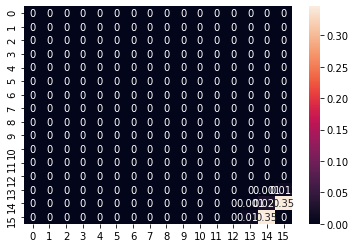

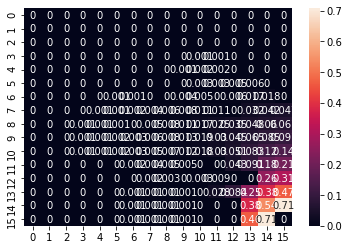

In [378]:
# Experiment 1:
# 16x16 Grid
# Gamma at .1
# Value Iteration and Policy Iteration

gamma = .1

env = gym.make('FrozenLake-v0', desc=map16x16)
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()

Value Iteration Value Array:
[1.05091024e-17 5.64820079e-18 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.45681379e-14 1.06116787e-13
 2.22570907e-13 1.00673775e-12 0.00000000e+00 7.91918103e-13
 9.04253772e-13 0.00000000e+00 0.00000000e+00 5.47689989e-14
 4.20364096e-17 1.77319015e-17 5.87067989e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.66723903e-13 3.08013029e-13
 0.00000000e+00 4.81111782e-12 1.38107516e-11 3.05533674e-12
 3.72935075e-12 1.74576710e-12 6.07196059e-13 2.19075996e-13
 1.92450146e-16 0.00000000e+00 3.34508892e-16 1.94834655e-15
 0.00000000e+00 1.68830819e-13 6.37762248e-13 1.57523748e-12
 4.48613264e-12 1.40492176e-11 7.49980551e-11 0.00000000e+00
 1.75750007e-11 6.13805577e-12 1.67833326e-12 4.88183919e-13
 9.20214322e-16 2.09139619e-15 0.00000000e+00 1.13555704e-14
 0.00000000e+00 3.75222668e-13 2.08250519e-12 4.32753002e-12
 1.12923408e-11 0.00000000e+00 4.22128361e-10 5.38413018e-10
 9.55825976e-11 1.75075669e-11 3.32474774e-12 7.62586332

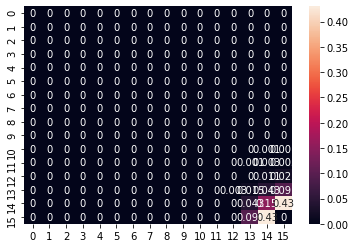

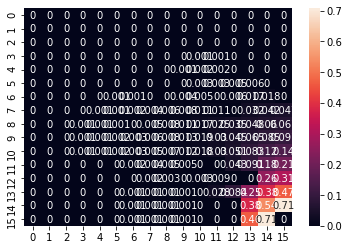

In [379]:
# Experiment 2:
# 16x16 Grid
# Gamma at .5
# Value Iteration and Policy Iteration

gamma = .5

env = gym.make('FrozenLake-v0', desc=map16x16)
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()

Value Iteration Value Array:
[4.59250941e-06 3.39627069e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.59161849e-05 5.99486025e-05
 6.32351352e-05 8.76000462e-05 0.00000000e+00 9.04717826e-05
 9.11952981e-05 0.00000000e+00 0.00000000e+00 5.02359415e-05
 6.12334589e-06 3.33212220e-06 1.58745743e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.05224957e-05 7.66449374e-05
 0.00000000e+00 1.41164973e-04 1.86896064e-04 1.19905528e-04
 1.22317246e-04 1.02978672e-04 8.05145004e-05 6.69812553e-05
 9.69529765e-06 0.00000000e+00 1.95940258e-06 4.94388449e-06
 0.00000000e+00 4.82529790e-05 1.02513863e-04 1.25012027e-04
 1.50431307e-04 1.96053798e-04 3.61916381e-04 0.00000000e+00
 1.84839954e-04 1.40430495e-04 9.84217405e-05 7.57750952e-05
 1.64990153e-05 1.58519951e-05 0.00000000e+00 1.45202124e-05
 0.00000000e+00 5.83294002e-05 1.46178355e-04 1.63761585e-04
 1.80371866e-04 0.00000000e+00 8.23438073e-04 8.12828487e-04
 3.53385439e-04 1.80283022e-04 1.07127473e-04 7.83868151

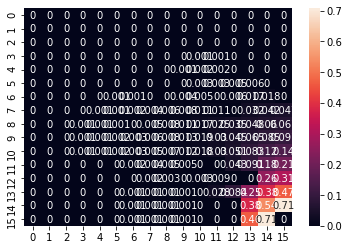

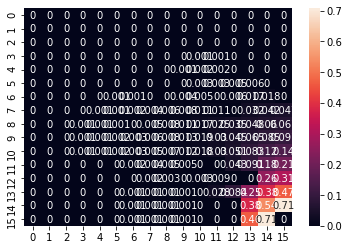

In [402]:
# Experiment 3:
# 16x16 Grid
# Gamma at .9
# Value Iteration and Policy Iteration

gamma = .9

env = gym.make('FrozenLake-v0', desc=map16x16)
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()

Value Iteration Value Array:
[1.11214545e-80 3.11400726e-79 0.00000000e+00 ... 1.19189834e-02
 3.45238586e-01 0.00000000e+00]
Value Iteration Output Policy:
[3, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 3, 2, 3, 2, 0, 0, 2, 3, 2, 1, 3, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 3, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 3, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 1, 1, 2, 3, 0, 0, 2, 1, 1, 1, 1, 1, 3, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 3, 0, 0, 2, 1, 3, 0, 0, 2, 1, 2, 1, 0, 0, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 1, 1, 3, 3, 2, 1, 2, 0, 0, 2, 1, 1, 0, 0, 2, 1, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 3, 2, 1, 1, 2, 2, 2, 2, 3, 3, 3, 2, 1, 0, 0, 2, 1, 1, 1, 1, 3, 3, 3, 2, 1, 1, 2, 1, 3, 0, 0, 0, 0, 2, 0, 0, 2, 2, 3, 0, 0, 0, 0, 2, 3, 1, 0, 0, 2, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 1, 3, 3, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 2, 1, 1, 1, 3, 3, 1, 2, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, 2, 0,

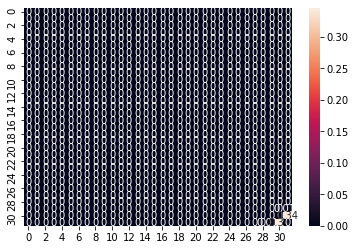

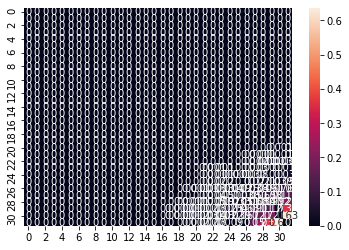

In [403]:
# Experiment 4:
# 32x32 Grid
# Gamma at .1
# Value Iteration and Policy Iteration

gamma = .1

env = gym.make('FrozenLake-v0', desc=map32x32)
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()

Value Iteration Value Array:
[7.13379242e-36 2.85351697e-35 0.00000000e+00 ... 8.72212815e-02
 4.17444256e-01 0.00000000e+00]
Value Iteration Output Policy:
[3, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 3, 2, 3, 2, 0, 0, 2, 3, 2, 1, 3, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 3, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 3, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 1, 1, 2, 3, 0, 0, 2, 1, 1, 1, 1, 1, 3, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 3, 0, 0, 2, 1, 3, 0, 0, 2, 1, 2, 1, 0, 0, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 1, 1, 3, 3, 2, 1, 2, 0, 0, 2, 1, 1, 0, 0, 2, 1, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 1, 0, 0, 2, 3, 2, 1, 1, 2, 2, 2, 2, 3, 3, 3, 2, 1, 0, 0, 2, 1, 1, 1, 1, 3, 3, 3, 2, 1, 1, 2, 1, 3, 0, 0, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 0, 2, 3, 1, 0, 0, 2, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 1, 3, 3, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 2, 1, 1, 1, 3, 3, 1, 1, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, 2, 0,

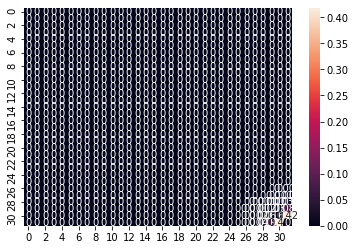

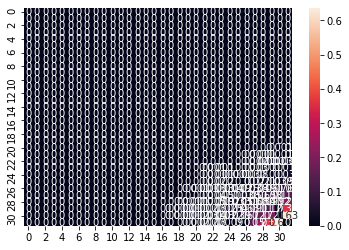

In [405]:
# Experiment 5:
# 16x16 Grid
# Gamma at .5
# Value Iteration and Policy Iteration

gamma = .5

env = gym.make('FrozenLake-v0', desc=map32x32)
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()

Value Iteration Value Array:
[9.68566822e-13 1.29142243e-12 0.00000000e+00 ... 3.70347250e-01
 6.34910726e-01 0.00000000e+00]
Value Iteration Output Policy:
[3, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 3, 2, 3, 2, 0, 0, 2, 3, 2, 3, 3, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2, 3, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 1, 1, 1, 3, 0, 0, 2, 1, 1, 1, 1, 1, 3, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 3, 0, 0, 2, 1, 3, 0, 0, 2, 1, 2, 1, 0, 0, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2, 2, 3, 3, 2, 3, 2, 0, 0, 2, 1, 1, 0, 0, 2, 1, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 3, 2, 1, 1, 2, 2, 2, 2, 3, 3, 3, 2, 2, 0, 0, 2, 1, 1, 1, 0, 3, 3, 3, 2, 1, 1, 2, 1, 3, 0, 0, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 0, 2, 3, 2, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 1, 3, 3, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 2, 2, 1, 0, 3, 3, 1, 2, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, 2, 0,

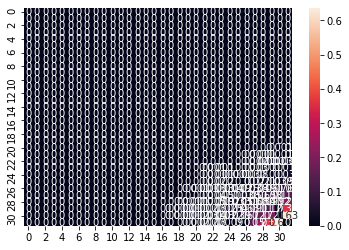

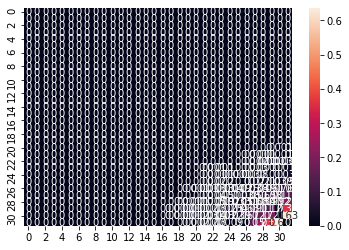

In [406]:
# Experiment 6:
# 32x32 Grid
# Gamma at .9
# Value Iteration and Policy Iteration

gamma = .9

env = gym.make('FrozenLake-v0', desc=map32x32)
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()

In [407]:
# Experiment 7:
# 40x40 Grid
# Gamma at .1
# Value Iteration and Policy Iteration

gamma = .1

env = gym.make('FrozenLake-v0', desc=map40x40)
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)


Value Iteration Value Array:
[4.11962121e-102 2.63348663e-101 5.19483835e-100 ... 1.19189681e-002
 3.45238585e-001 0.00000000e+000]
Value Iteration Output Policy:
[1, 2, 2, 2, 0, 0, 2, 1, 2, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 3, 3, 2, 1, 2, 1, 1, 1, 1, 0, 0, 2, 2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 3, 3, 1, 1, 2, 0, 3, 0, 0, 2, 3, 3, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 0, 0, 2, 2, 3, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 3, 1, 2, 3, 2, 1, 1, 1, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 2, 1, 1, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 3, 0, 0, 2, 0, 0, 2, 1, 3, 1, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 2, 3, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 2, 3, 1, 3, 1, 1, 0, 0, 2, 2, 1, 3, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0,

In [408]:
# Experiment 8:
# 40x40 Grid
# Gamma at .5
# Value Iteration and Policy Iteration

gamma = .5

env = gym.make('FrozenLake-v0', desc=map40x40)
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)


Value Iteration Value Array:
[3.40328665e-45 3.88916341e-45 9.53719561e-45 ... 8.71217347e-02
 4.17424347e-01 0.00000000e+00]
Value Iteration Output Policy:
[2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 3, 3, 2, 1, 2, 1, 1, 1, 1, 0, 0, 2, 2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 3, 3, 1, 1, 2, 0, 3, 0, 0, 2, 3, 3, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 0, 0, 2, 2, 3, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 3, 1, 2, 3, 2, 1, 1, 1, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 2, 1, 1, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 3, 0, 0, 2, 0, 0, 2, 1, 3, 1, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 3, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 2, 3, 1, 3, 1, 1, 0, 0, 2, 2, 1, 3, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1,

In [409]:
# Experiment 9:
# 40x40 Grid
# Gamma at .9
# Value Iteration and Policy Iteration

gamma = .9

env = gym.make('FrozenLake-v0', desc=map40x40)
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)


Value Iteration Value Array:
[1.44720865e-15 1.34314464e-15 1.14241106e-15 ... 3.57479791e-01
 6.29396101e-01 0.00000000e+00]
Value Iteration Output Policy:
[0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0, 3, 3, 2, 1, 2, 1, 1, 0, 1, 0, 0, 2, 2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 3, 3, 1, 1, 2, 0, 3, 0, 0, 2, 3, 3, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 2, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 2, 2, 3, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 3, 1, 1, 3, 2, 1, 1, 1, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 2, 1, 1, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 3, 0, 0, 2, 0, 0, 2, 1, 3, 1, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 3, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 2, 3, 1, 3, 1, 1, 0, 0, 2, 2, 1, 3, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1,

In [525]:
# Finish Up VI and PI with 16, 32, and 40 squares

In [527]:
# Experiment 9.5:
# Frozen Lake
# 16x16 Grid
# QLearning

# def gym_qlearning(env, total_episodes=100, max_steps=10000, lr_rate=.81, 
#                   gamma=.96, epsilon =.9, decay_eps=False, decay_lr=False):

gammas = [.001, .1, .5, .9, .95]
lrs = gammas
epsilons = [.001, .1, .5, .9, 1]
decays = [False, True]

outputs = []
env = gym.make('FrozenLake-v0', desc=map16x16)
for combo in itertools.product(gammas, gammas, epsilons, decays, decays):
    Q, iters = gym_qlearning(env, lr_rate=combo[1], gamma=combo[0], epsilon=combo[2], decay_eps=[3], decay_lr=combo[4])
    outputs.append(Q)

In [528]:
outputs

[array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]), array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]), array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]), array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]), array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]), array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
       

In [537]:
# Experiment 9.5:
# Frozen Lake
# 16x16 Grid
# QLearning

# def gym_qlearning(env, total_episodes=100, max_steps=10000, lr_rate=.81, 
#                   gamma=.96, epsilon =.9, decay_eps=False, decay_lr=False):

gammas = [.001, .1, .5, .9, .95]
lrs = gammas
epsilons = [.001, .1, .5, .9, 1]
decays = [False, True]

new_outputs = []
env = gym.make('FrozenLake-v0', map_name='8x8')
for combo in itertools.product(gammas, gammas, epsilons, decays, decays):
    Q, iters = gym_qlearning(env, total_episodes=500, max_steps= 100000, lr_rate=combo[1], gamma=combo[0], epsilon=combo[2], decay_eps=[3], decay_lr=combo[4])
    new_outputs.append(Q)

10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
50000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
10000
10000
10000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
10000
10000
10000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
4000

20000
30000
40000
50000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
50000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
10000
10000
10000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
50000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
10000
10000
10000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
40000
10000
20000
30000
4000

In [538]:
new_outputs

[array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0.,

In [542]:
 q8x8 = np.array([[1.84139501e-02, 1.69227593e-02, 1.84238893e-02, 1.87513149e-02],
        [1.88485976e-02, 1.95341760e-02, 1.94311705e-02, 1.97905594e-02],
        [1.87873564e-02, 1.90032989e-02, 2.09089838e-02, 1.89064687e-02],
        [1.98690546e-02, 2.20669303e-02, 2.01288157e-02, 1.99674738e-02],
        [2.09240015e-02, 2.12539004e-02, 1.86987775e-02, 2.10777867e-02],
        [2.17574208e-02, 2.48814743e-02, 2.36306963e-02, 2.24513128e-02],
        [2.52362365e-02, 2.51361582e-02, 2.65202406e-02, 2.39043344e-02],
        [2.51612372e-02, 2.51703340e-02, 2.50129953e-02, 2.49537034e-02],
        [1.77776878e-02, 1.95002490e-02, 1.73064035e-02, 1.68992172e-02],
        [1.84516200e-02, 2.05452554e-02, 1.83139555e-02, 1.63686891e-02],
        [1.99099730e-02, 1.82015018e-02, 1.93801653e-02, 1.98637311e-02],
        [9.98267447e-04, 1.00688520e-03, 2.32868696e-02, 2.11292621e-02],
        [0.00000000e+00, 2.22488830e-02, 2.29189586e-02, 2.21220044e-02],
        [2.42870928e-02, 1.90119739e-02, 2.63039133e-02, 2.06556172e-02],
        [2.54196548e-02, 3.16542201e-02, 2.63331014e-02, 2.79173131e-02],
        [2.49750273e-02, 3.00395170e-02, 3.35668985e-02, 2.39344224e-02],
        [1.71758701e-02, 1.62990169e-02, 1.62796874e-02, 1.63581026e-02],
        [1.77550601e-02, 1.71387372e-02, 1.91483204e-02, 1.73447261e-02],
        [1.88504010e-02, 1.65912172e-02, 7.41219664e-04, 1.89559411e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.30317817e-02, 2.22870981e-02, 0.00000000e+00],
        [0.00000000e+00, 2.07913919e-02, 2.54498218e-02, 2.35017769e-03],
        [2.58839097e-02, 2.93417341e-02, 2.67709700e-02, 2.25666994e-02],
        [2.78816963e-02, 2.93950663e-02, 3.20866599e-02, 2.95877974e-02],
        [1.00003889e-02, 8.89749857e-03, 9.28725687e-03, 1.61809667e-02],
        [1.72161733e-02, 1.60671896e-02, 1.36768051e-02, 1.58371677e-02],
        [1.57758938e-02, 9.79833788e-03, 1.84131523e-02, 1.78742748e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.68392169e-04],
        [0.00000000e+00, 0.00000000e+00, 4.25702033e-05, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.70178355e-02, 2.83096218e-02, 2.68648992e-02, 2.69504594e-02],
        [3.41759160e-02, 3.01700837e-02, 3.79980293e-02, 2.99480324e-02],
        [4.75915810e-04, 4.74362583e-04, 9.34552520e-03, 8.06788923e-03],
        [8.92315419e-08, 0.00000000e+00, 4.21116750e-04, 1.43613609e-02],
        [0.00000000e+00, 1.10537499e-06, 9.71106258e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.15912517e-02, 0.00000000e+00, 2.57312719e-02],
        [2.98655598e-02, 0.00000000e+00, 3.65010304e-02, 3.78355203e-02],
        [3.63105909e-02, 3.60625766e-02, 3.68766215e-02, 3.79824083e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.56926167e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.86212625e-02, 0.00000000e+00, 8.57375000e-01, 3.81593633e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.88689047e-01, 0.00000000e+00, 9.50000000e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
    
policy = get_qpolicy(q8x8)
print(policy)

[3, 3, 2, 1, 1, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 0, 2, 3, 0, 1, 2, 1, 2, 3, 0, 2, 3, 2, 0, 1, 2, 2, 3, 2, 0, 0, 1, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Value Iteration Value Array:
[2.90471967e-18 6.09966357e-17 1.29210144e-15 2.69999468e-14
 5.26614876e-13 7.61779498e-12 9.54734125e-11 6.08620831e-10
 2.32402346e-17 4.76800995e-16 1.04709951e-14 2.56383579e-13
 7.65403644e-12 1.25442642e-10 2.16010813e-09 1.70413833e-08
 1.97165808e-16 3.77203815e-15 5.64541710e-14 0.00000000e+00
 1.03651837e-10 1.59551708e-09 4.76364181e-08 4.92040006e-07
 1.94577028e-15 5.62301724e-14 1.67938210e-12 5.02687786e-11
 1.50638398e-09 0.00000000e+00 9.34892427e-07 1.42215238e-05
 1.96441563e-16 3.75103506e-15 5.61044378e-14 0.00000000e+00
 4.50375986e-08 9.04189927e-07 1.37776126e-05 4.11489297e-04
 7.62079783e-18 0.00000000e+00 0.00000000e+00 1.48642558e-08
 4.45431648e-07 1.33030476e-05 0.00000000e+00 1.19189681e-02
 2.45615738e-17 0.00000000e+00 1.65532818e-11 4.96026970e-10
 0.00000000e+00 3.97741806e-04 0.00000000e+00 3.45238585e-01
 7.04664841e-16 1.97306156e-14 5.71483186e-13 0.00000000e+00
 4.10998315e-04 1.19189511e-02 3.45238585e-01 0.00000000

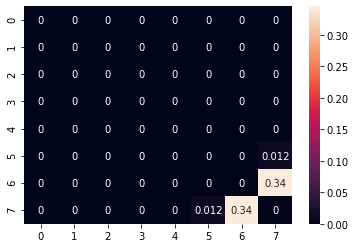

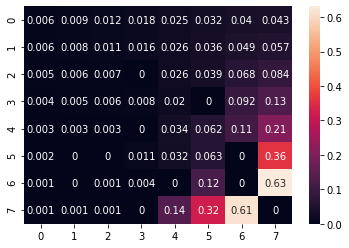

Value Iteration Value Array:
[2.31052312e-08 8.66989853e-08 3.28061680e-07 1.22041932e-06
 4.26265365e-06 1.19169189e-05 2.93131452e-05 4.76476277e-05
 2.88271708e-08 1.05433247e-07 4.19889076e-07 1.83944296e-06
 9.39634937e-06 3.02714493e-05 9.89180982e-05 1.90590511e-04
 3.87026071e-08 1.26011421e-07 3.51829813e-07 0.00000000e+00
 2.18439933e-05 7.07936786e-05 3.72646629e-04 8.54034455e-04
 6.75016145e-08 2.98805466e-07 1.56507838e-06 8.73983501e-06
 5.08739317e-05 0.00000000e+00 1.28292722e-03 3.89752565e-03
 3.38489212e-08 1.01742992e-07 2.77803562e-07 0.00000000e+00
 2.74659762e-04 1.07671813e-03 3.42739106e-03 1.82047010e-02
 8.26320769e-09 0.00000000e+00 0.00000000e+00 8.92812746e-05
 5.20366504e-04 2.75825799e-03 0.00000000e+00 8.71259794e-02
 7.46711725e-09 0.00000000e+00 2.64558645e-06 1.53211435e-05
 0.00000000e+00 1.49524633e-02 0.00000000e+00 4.17425196e-01
 2.90723786e-08 1.16289514e-07 5.52375193e-07 0.00000000e+00
 1.73913043e-02 8.69565217e-02 4.17391304e-01 0.00000000

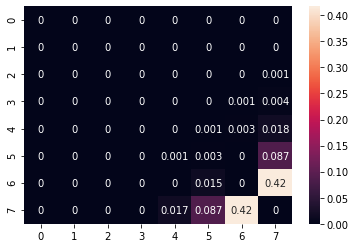

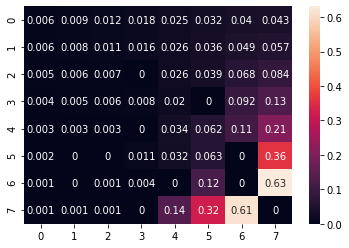

Value Iteration Value Array:
[0.00641111 0.00854815 0.0123005  0.01778948 0.02508218 0.03247093
 0.03957138 0.04297848 0.00602413 0.00764519 0.01091169 0.0164266
 0.02605416 0.03619413 0.04935474 0.05730465 0.00509032 0.00585328
 0.00677541 0.         0.02557088 0.03882143 0.06763977 0.0843561
 0.00422568 0.00476961 0.00581975 0.00785413 0.02036068 0.
 0.09175505 0.12919114 0.00318101 0.00319666 0.00270492 0.
 0.03444393 0.06195147 0.10901924 0.20969095 0.00186925 0.
 0.         0.0108508  0.03250094 0.06304174 0.         0.36008775
 0.00118058 0.         0.00137719 0.0036684  0.         0.11568672
 0.         0.6305138  0.00088543 0.00077472 0.00092225 0.
 0.13824885 0.32258065 0.61443932 0.        ]
Value Iteration Output Policy:
[3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 1, 3, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 0]
Value Iteration - Time per iteration:
0.0012384038062611962
Value

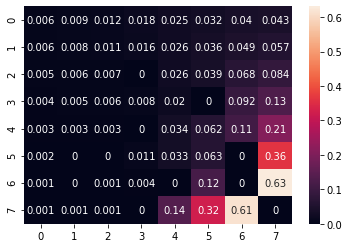

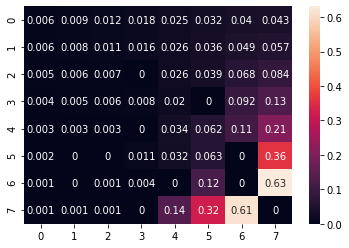

In [543]:
# 8x8 VI PI Frozen lake
gammas = [.1, .5, .9]
for gamma in gammas:
    env = gym.make('FrozenLake-v0', map_name='8x8')
    vi_start = time.time()
    value, vi_iters = value_iteration(env, lmbda=gamma)
    vi_total = time.time() - vi_start
    vi_policy = get_policy(env, value, gamma)
    pi_start = time.time()
    pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
    pi_total = time.time() - pi_start

    prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
    prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
    compare_policies(vi_policy, pi_policy)
    compare_values(value, vfunc)

    #Graphing
    sideLen = int(np.sqrt(env.nS))

    value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
    vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

    sns.heatmap(value, annot=True)
    plt.show()
    sns.heatmap(vfunc, annot=True)
    plt.show()
    

In [548]:
compare_policies(policy, [3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 1, 3, 3, 0, 0, 2,
 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0 ,0, 1, 0 ,0, 0, 0, 2, 0, 1, 0 ,0 ,1, 1, 1, 0])


There were 37 differences in the policies



In [ ]:
# Start Forest Management

In [507]:
# Experiment 10:
# Forest Management
# 10 States
# Gamma at .1
# Value Iteration and Policy Iteration

# transitions, reward, discount, policy0=None, max_iter=1000, eval_type=0, skip_check=False)

gamma = .1
P, R = ex.forest(S=10)
pi = PolicyIteration(P, R, discount=gamma, max_iter=10000, eval_type=1)
pi.run()
print(pi.V)
print(pi.policy)
print(pi.iter)


vi = ValueIteration(P, R, discount=gamma, max_iter=10000)
vi.run()
print(vi.V)
print(vi.policy)
print(vi.iter)
print()
print(eval_qpolicy(vi.policy))

(0.09173529000000001, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 4.39658473)
(0, 1, 1, 1, 1, 1, 1, 1, 1, 0)
1
(0.09000000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.36)
(0, 1, 1, 1, 1, 1, 1, 1, 1, 0)
2

24


In [508]:
# Experiment 11:
# Forest Management
# 10 States
# Gamma at .5
# Value Iteration and Policy Iteration

# transitions, reward, discount, policy0=None, max_iter=1000, eval_type=0, skip_check=False)

gamma = .5
P, R = ex.forest(S=10)
pi = PolicyIteration(P, R, discount=gamma, max_iter=10000, eval_type=1)
pi.run()
print(pi.V)
print(pi.policy)
print(pi.iter)

vi = ValueIteration(P, R, discount=gamma, max_iter=10000)
vi.run()
print(vi.V)
print(vi.policy)
print(vi.iter)
print()
print(eval_qpolicy(vi.policy))


(0.6206586911623433, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.5290848230321827, 3.3290848230321832, 7.329084823032183)
(0, 1, 1, 1, 1, 1, 1, 0, 0, 0)
3
(0.6175383117187501, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.5147218953125, 3.3147218953125, 7.3147218953125)
(0, 1, 1, 1, 1, 1, 1, 0, 0, 0)
8

28


In [509]:
# Experiment 12:
# Forest Management
# 10 States
# Gamma at .9
# Value Iteration and Policy Iteration

# transitions, reward, discount, policy0=None, max_iter=1000, eval_type=0, skip_check=False)

gamma = .9
P, R = ex.forest(S=10)
pi = PolicyIteration(P, R, discount=gamma, max_iter=10000, eval_type=1)
pi.run()
print(pi.V)
print(pi.policy)
print(pi.iter)
print(pi.time)
print(pi.time/pi.iter)

vi = ValueIteration(P, R, discount=gamma, max_iter=10000)
vi.run()
print(vi.V)
print(vi.policy)
print(vi.iter)
print(vi.time)
print(vi.time/vi.iter)
print()
print(eval_qpolicy(vi.policy))

(6.003691247066084, 6.744899322606822, 7.659971020805262, 8.789689166729264, 10.184402927129264, 11.906271767129263, 14.032035767129265, 16.65643576712927, 19.896435767129265, 23.896435767129265)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
9
0.004947185516357422
0.0005496872795952691
(3.772106445047769, 4.513314520588507, 5.428386218786945, 6.5581043647109425, 7.9528181251109435, 9.674686965110944, 11.800450965110945, 14.424850965110947, 17.664850965110947, 21.664850965110947)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
16
0.00027441978454589844
1.7151236534118652e-05

40


In [510]:
# Experiment 13:
# Forest Management
# 20 States
# Gamma at .1
# Value Iteration and Policy Iteration

# transitions, reward, discount, policy0=None, max_iter=1000, eval_type=0, skip_check=False)

gamma = .1
P, R = ex.forest(S=20)
pi = PolicyIteration(P, R, discount=gamma, max_iter=10000, eval_type=1)
pi.run()
print(pi.V)
print(pi.policy)
print(pi.iter)

vi = ValueIteration(P, R, discount=gamma, max_iter=10000)
vi.run()
print(vi.V)
print(vi.policy)
print(vi.iter)

print()
print(eval_qpolicy(vi.policy))

(0.09173529000000001, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 4.39658473)
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)
1
(0.09000000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.36)
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)
2

44


In [511]:
# Experiment 14:
# Forest Management
# 20 States
# Gamma at .5
# Value Iteration and Policy Iteration

# transitions, reward, discount, policy0=None, max_iter=1000, eval_type=0, skip_check=False)

gamma = .5
P, R = ex.forest(S=20)
pi = PolicyIteration(P, R, discount=gamma, max_iter=10000, eval_type=1)
pi.run()
print(pi.V)
print(pi.policy)
print(pi.iter)

vi = ValueIteration(P, R, discount=gamma, max_iter=10000)
vi.run()
print(vi.V)
print(vi.policy)
print(vi.iter)

print()
print(eval_qpolicy(vi.policy))

(0.6206586911623433, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.5290848230321827, 3.3290848230321832, 7.329084823032183)
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0)
3
(0.6175383117187501, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.5147218953125, 3.3147218953125, 7.3147218953125)
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0)
8

48


In [512]:
# Experiment 15:
# Forest Management
# 20 States
# Gamma at .9
# Value Iteration and Policy Iteration

# transitions, reward, discount, policy0=None, max_iter=1000, eval_type=0, skip_check=False)

gamma = .9
P, R = ex.forest(S=20)
pi = PolicyIteration(P, R, discount=gamma, max_iter=10000, eval_type=1)
pi.run()
print(pi.V)
print(pi.policy)
print(pi.iter)

vi = ValueIteration(P, R, discount=gamma, max_iter=10000)
vi.run()
print(vi.V)
print(vi.policy)
print(vi.iter)

print()
print(eval_qpolicy(vi.policy))

(4.475046400744577, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.279597599379861, 6.0208056749206, 6.935877373119039, 8.065595519043036, 9.460309279443042, 11.18217811944304, 13.307942119443043, 15.93234211944304, 19.17234211944304, 23.17234211944304)
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
10
(4.3972734135838945, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 5.196930571860685, 5.938138647401423, 6.853210345599864, 7.982928491523864, 9.377642251923863, 11.099511091923867, 13.225275091923866, 15.849675091923864, 19.089675091923866, 23.089675091923866)
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
39

62


In [513]:
# Experiment 16:
# Forest Management
# 30 States
# Gamma at .1
# Value Iteration and Policy Iteration

# transitions, reward, discount, policy0=None, max_iter=1000, eval_type=0, skip_check=False)

gamma = .1
P, R = ex.forest(S=30)
pi = PolicyIteration(P, R, discount=gamma, max_iter=10000, eval_type=1)
pi.run()
print(pi.V)
print(pi.policy)
print(pi.iter)

vi = ValueIteration(P, R, discount=gamma, max_iter=10000)
vi.run()
print(vi.V)
print(vi.policy)
print(vi.iter)

compare_policies(pi.policy, vi.policy)

print()
print(eval_qpolicy(vi.policy))


(0.09173529000000001, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 1.0091719, 4.39658473)
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)
1
(0.09000000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.36)
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)
2
The policies are equal


64


In [514]:
# Experiment 17:
# Forest Management
# 30 States
# Gamma at .5
# Value Iteration and Policy Iteration

# transitions, reward, discount, policy0=None, max_iter=1000, eval_type=0, skip_check=False)

gamma = .5
P, R = ex.forest(S=30)
pi = PolicyIteration(P, R, discount=gamma, max_iter=10000, eval_type=1)
pi.run()
print(pi.V)
print(pi.policy)
print(pi.iter)

vi = ValueIteration(P, R, discount=gamma, max_iter=10000)
vi.run()
print(vi.V)
print(vi.policy)
print(vi.iter)

compare_policies(pi.policy, vi.policy)

print()
print(eval_qpolicy(vi.policy))

(0.6206586911623433, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.3103181968855908, 1.5290848230321827, 3.3290848230321832, 7.329084823032183)
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0)
3
(0.6175383117187501, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.3060338203125, 1.306033820312

In [515]:
# Experiment 18:
# Forest Management
# 30 States
# Gamma at .9
# Value Iteration and Policy Iteration

# transitions, reward, discount, policy0=None, max_iter=1000, eval_type=0, skip_check=False)

gamma = .9
P, R = ex.forest(S=30)
pi = PolicyIteration(P, R, discount=gamma, max_iter=10000, eval_type=1)
pi.run()
print(pi.V)
print(pi.policy)
print(pi.iter)

vi = ValueIteration(P, R, discount=gamma, max_iter=10000)
vi.run()
print(vi.V)
print(vi.policy)
print(vi.iter)

compare_policies(pi.policy, vi.policy)


print()
print(eval_qpolicy(vi.policy))

(4.475046400744577, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.027532588797029, 5.279597599379862, 6.020805674920599, 6.935877373119039, 8.065595519043036, 9.460309279443042, 11.18217811944304, 13.307942119443043, 15.93234211944304, 19.17234211944304, 23.17234211944304)
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
10
(4.3972734135838945, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.949908618890849, 4.9499086

In [493]:
# Experiment 19:
# Forest Management
# Variable States
# Gamma Variable
# Value Iteration and Policy Iteration

# transitions, reward, discount, policy0=None, max_iter=1000, eval_type=0, skip_check=False)

    
def compare(p1, p2):
    p1, p2 = np.array(p1), np.array(p2)
    return np.array_equal(p1, p2)

start = time.time()
gammas = [.0001, .001, .1, .2, .35, .5, .7, .9, .999]
ss = [30, 50, 100, 500]
probs = np.arange(.05, .5, .05)
iters = [500, 1000, 5000, 10000]
for combo in itertools.product(gammas, ss, probs,iters):
    P, R = ex.forest(S=combo[1], p=combo[2])
    pi = PolicyIteration(P, R, discount=combo[0], max_iter=combo[3], eval_type=1)
    pi.run()

    vi = ValueIteration(P, R, discount=gamma, max_iter=10000)
    vi.run()

    if not compare(pi.policy, vi.policy):
        print(combo)
        print(pi.policy)
        print(vi.policy)
        break


print(time.time() - start)

(0.35, 30, 0.05, 500)
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0)
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)
1.9793095588684082


In [520]:
# Forest Management QLearning
# Gamma = All Gammas
# States: 10

ten_scores = []
twenty_scores = []
thirty_scores = []

for gamma in [.1, .5, .9]:
    P, R = ex.forest(S=10)
    ql = QLearning(P, R, gamma, n_iter=30000)
    ql.run()
    print(ql.policy)
    print(eval_qpolicy(ql.policy))
    ten_scores.append(eval_qpolicy(ql.policy))

print()

for gamma in [.1, .5, .9]:
    P, R = ex.forest(S=20)
    ql = QLearning(P, R, gamma, n_iter=30000)
    ql.run()
    print(ql.policy)
    print(eval_qpolicy(ql.policy))
    twenty_scores.append(eval_qpolicy(ql.policy))

print()

for gamma in [.1, .5, .9]:
    P, R = ex.forest(S=30)
    ql = QLearning(P, R, gamma, n_iter=30000)
    ql.run()
    print(ql.policy)
    print(eval_qpolicy(ql.policy))
    thirty_scores.append(eval_qpolicy(ql.policy))
print()

(0, 1, 1, 0, 1, 1, 0, 1, 0, 0)
30
(0, 1, 1, 0, 1, 0, 1, 0, 0, 1)
30
(0, 1, 1, 1, 0, 0, 1, 1, 1, 0)
28

(0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0)
52
(0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0)
54
(0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0)
60

(0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0)
88
(0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0)
90
(0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0)
92

